# Group 96

In [123]:
import numpy as np
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
from sklearn.feature_extraction.image import extract_patches_2d
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models,Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Reshape
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
# ReduceLROnPlateau
from keras.callbacks import ReduceLROnPlateau
 

## extract patches 2d

Reshape a 2D image into a collection of patches of the choosen size.
The resulting patches are allocated in a dedicated array.

## reconstruct from patches 2d

Reconstruct the image from all of its patches.
Patches are assumed to overlap and the image is constructed by filling in the patches from left to right, top to bottom, averaging the overlapping regions.

# Data Importation

In [91]:
# Importing the training patched dataset
Xtrain_a = np.load('Xtrain2_a.npy')
Ytrain_a = np.load('Ytrain2_a.npy')

# Importing the training flattened dataset
Xtrain_b = np.load('Xtrain2_b.npy')
Ytrain_b = np.load('Ytrain2_b.npy')

In [92]:
# Imbalance in the dataset a?
print('Number of samples in class 0:', np.sum(Ytrain_a == 0))
print('Number of samples in class 1:', np.sum(Ytrain_a == 1))
print("Percentage of samples in class 1: ", (np.sum(Ytrain_a == 1)/np.sum(Ytrain_a==0))*100)

# Imbalance in the dataset b?
print('Number of samples in class 0:', np.sum(Ytrain_b == 0))
print('Number of samples in class 1:', np.sum(Ytrain_b == 1))
print("Percentage of samples in class 1: ", (np.sum(Ytrain_b == 1)/np.sum(Ytrain_b==0))*100)

Number of samples in class 0: 649624
Number of samples in class 1: 315284
Percentage of samples in class 1:  48.5333054197505
Number of samples in class 0: 896429
Number of samples in class 1: 363859
Percentage of samples in class 1:  40.58982920008166


# Data Visualization

Shape of the training dataset a: 547.0


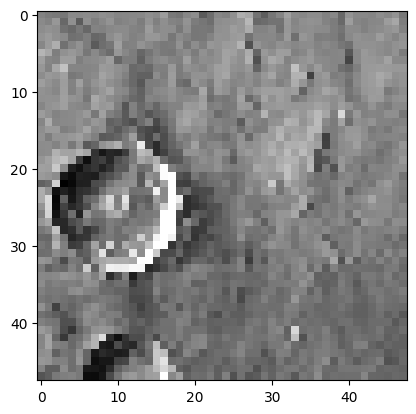

In [93]:
print('Shape of the training dataset a:', Xtrain_a.shape[0]/1764)
# Size of an image
img_size = [48,48]
# Number of patches for one image
patches = np.array(Xtrain_a[0:1764])

# Reshaping the patches
patches = patches.reshape(-1, 7, 7)
# Reconstructing the image
img_0_a = reconstruct_from_patches_2d(patches = patches, image_size=img_size ) 

# The image most be reshaped into a 48x48 matrix
img_0_a = img_0_a.reshape(1,48,48)
plt.imshow(img_0_a[0], cmap='gray')
plt.show()


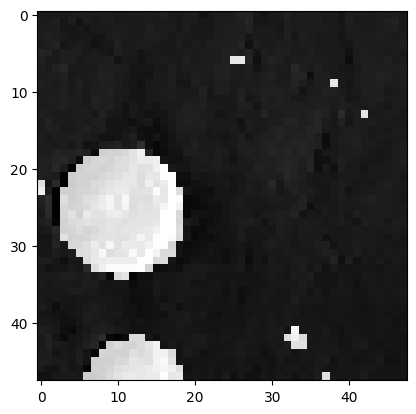

In [94]:
# Each line in the dataset b is a 2D image of 48x48 pixels
Xtrain_b_img = Xtrain_b.reshape(-1, 48, 48)
Ytrain_b_img = Ytrain_b.reshape(-1, 48,48)

# Displaying the first image and the y image
plt.imshow(Xtrain_b_img[0], cmap='gray')
plt.imshow(Ytrain_b_img[0], cmap='gray', alpha=0.8)
plt.show()

## Splitting the data

In [95]:
# Splitting the dataset a
Xtrain_a, Xval_a, Ytrain_a, Yval_a = train_test_split(Xtrain_a, Ytrain_a, test_size=0.2, random_state=42)

# Splitting the dataset b
Xtrain_b, Xval_b, Ytrain_b, Yval_b = train_test_split(Xtrain_b, Ytrain_b, test_size=0.2, random_state=42) 

# Convolutional Neural : U-NET

## Data processing

In [96]:
# Normalizing the training dataset
Xtrain_a = Xtrain_a/255
Xtrain_b = Xtrain_b/255

# Normalizing the validation dataset
Xval_a = Xval_a/255
Xval_b = Xval_b/255


## Creating the model 

In [132]:
def unet_model(input_shape=(48, 48, 1)):
    inputs = layers.Input(shape=input_shape)

    # Encode
    # Convolutions 1 + Reduction
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    # Convolutions 2 + Reduction
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Convolutions 3 + Reduction
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Convolutions 4 + Reduction
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c5)

    # Upconvolutions + Concatenations of the encoder + Convolutions
    u6 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c6)

    # Upconvolutions + Concatenations of the encoder + Convolutions
    u7 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c7)

    # Upconvolutions + Concatenations of the encoder + Convolutions
    u8 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c8)

    # Upconvolutions + Concatenations of the encoder + Convolutions
    u9 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c9)

    # Convolution for the output
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)  # Sortie de segmentation

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

In [138]:
# Epochs
epochs = 200
# Batch size
batch_size = 20
# Leraning rate
lr = 0.001

In [141]:
rmsprop = tf.keras.optimizers.RMSprop(learning_rate=lr)

# Method to reduce the learning rate when the validation loss does not improve
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

adam = tf.keras.optimizers.Adam(learning_rate=lr)


## Training the model

In [142]:
model_img = unet_model()
model_img.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model_img.summary()

Xtrain_b_mat= Xtrain_b.reshape(-1, 48, 48, 1)
Ytrain_b_mat = Ytrain_b.reshape(-1, 48, 48,1) 

print(Xtrain_b_mat.shape)
print(Ytrain_b_mat.shape)

Xval_b_mat = Xval_b.reshape(-1, 48, 48, 1)
Yval_b_mat = Yval_b.reshape(-1, 48, 48,1)


history = model_img.fit(Xtrain_b_mat, Ytrain_b_mat,
                    batch_size=batch_size, 
                    epochs=epochs, 
                    verbose=1, 
                    validation_data=(Xval_b_mat, Yval_b_mat),
                    callbacks=[reduce_lr, early_stopping]
                   )

Model: "functional_190"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_130 (Conv2D) │ (None, 48, 48,    │        320 │ input_layer_17[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_131 (Conv2D) │ (None, 48, 48,    │      9,248 │ conv2d_130[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_53    │ (None, 24, 24,    │          0 │ conv2d_131[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_132 (Conv2D) │ (None, 24, 24,    │     18,496 │ max_pooling2d_53… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_133 (Conv2D) │ (None, 24, 24,    │     36,928 │ conv2d_132[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_54    │ (None, 12, 12,    │          0 │ conv2d_133[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_134 (Conv2D) │ (None, 12, 12,    │     73,856 │ max_pooling2d_54… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_135 (Conv2D) │ (None, 12, 12,    │    147,584 │ conv2d_134[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_55    │ (None, 6, 6, 128) │          0 │ conv2d_135[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_136 (Conv2D) │ (None, 6, 6, 256) │    295,168 │ max_pooling2d_55… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_137 (Conv2D) │ (None, 6, 6, 256) │    590,080 │ conv2d_136[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_56    │ (None, 3, 3, 256) │          0 │ conv2d_137[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_138 (Conv2D) │ (None, 3, 3, 512) │  1,180,160 │ max_pooling2d_56… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_139 (Conv2D) │ (None, 3, 3, 512) │  2,359,808 │ conv2d_138[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_8  │ (None, 6, 6, 256) │    524,544 │ conv2d_139[0][0]  │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 6, 6, 512) │          0 │ conv2d_transpose… │
│ (Concatenate)       │                   │            │ conv2d_137[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_140 (Conv2D) │ (None, 6, 6, 256) │  1,179,904 │ concatenate_8[0]… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 7,759,521 (29.60 MB)

 Trainable params: 7,759,521 (29.60 MB)

 Non-trainable params: 0 (0.00 B)

(437, 48, 48, 1)
(437, 48, 48, 1)
Epoch 1/200


/Users/sebastian/opt/anaconda3/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_1379']. Received: the structure of inputs=*
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.6487 - loss: 0.6515 - val_accuracy: 0.7060 - val_loss: 0.6187 - learning_rate: 0.0010
Epoch 2/200
 9/22 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.6977 - loss: 0.6251

KeyboardInterrupt: 

Best obtained so far -> rmsprop 

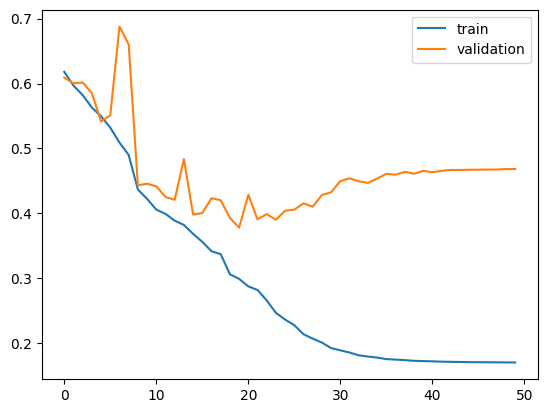

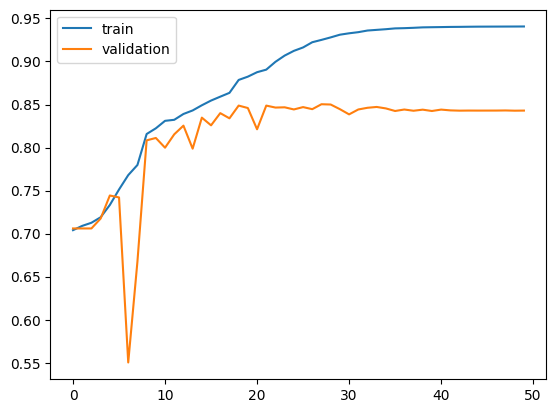

In [136]:
# The loss giving the epoch
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

# The accuracy giving the epoch
plt.plot(history.history['accuracy'], label='train')   
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.show()